<a href="https://colab.research.google.com/github/mpudig/MATH5271/blob/main/MATH5271_Lab_5_Statistical_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATH5271 Lab 5

# Statistical Forecasting

Welcome to the 5th MATH5271 lab session. In this lab we will discuss Statistical Forecasting. By the end of this lab you should be able to:

- Do simple linear regression and visualise results;
- Load and interogate a both Burau of of Meteorology station data and 2D numerical weather prediction (NWP) surface air temperature data;
- Develop a Model Output Statistics (MOS) model to relate the two.

## Google Colaboratory

We will run the python labs in [Google Colaboratory](colab.research.google.com). Google Colab is a web-based computational environment in which you can read, write, and execute interactive *notebooks* like the one you are reading. The python code runs on a virtual machine in the cloud, so you don't need to install python on your local machine. 

Before you begin the lab, you will need to [sign up](https://accounts.google.com/signup) for a free Google account. If you do not wish to sign up for a Google account, that's fine: you will still be able to read through the lab. You just won't be able to make edits or run any code. 

## Colaboratory and Google Drive

If you have a Google account, you can mount your Google drive within the Colab environment by copying and pasting the code below into a new cell (click "+ Code"). This is not required to run the lab (figures and movies will be saved to the Colab virtual machine and played in your browser). 
```
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/" "/content/"'
```

## 1. Setup and Load Data

Before we get started we need to ensure we have the appropriate 'libraries' are installed. You can think of these as opening a box of available tools. The .csv files we upload will be uploaded into a 'pandas' data frame. We will use the 'numpy' (numerical python) package to do some basic maths with the data and Matplotlib's 'pyplot' package to make some pretty graphs. 

In this lab we will also use xarray which is an extremely powerful and user frieldly tool for analysis of large multi-dimensional data sets. Here is a more in depth [tutorial](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html) just on xarray that I have built the second half of this lab from.

There are many other packages and libraries avaialble freely in python. We will experiment with a few in this course but will only really scratch the surface. I will try to keep things as simple as possible so we can focus on understanding - rather than trouble shooting technical issues.

In [ ]:
# import libraries
import pandas as pd
import xarray as xr

# Numerics
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# plot figures in Colaboratory notebook
%matplotlib inline

The first data set we look at will be example data table A1 from Wilks as we used in Lab 1.

We will load the data table as a pandas 'DataFrame'. This is a 2-dimensional data structure that can store data of different types and has inbuilt operations (like calcualting statistics and doing basic plots).

In [ ]:
# Define the URL where the data set is stored
TableA1_url = 'https://raw.githubusercontent.com/janzika/MATH5271/main/Wilks_TableA1.csv' 

# Import the data set as a Pandas Dataframe using the 'read_csv' function
df1 = pd.read_csv(TableA1_url)

## 2. Forecasting

When forecasting, we aim to predict the value of a specific 'predictand' $y_i$, as a function of a set of predictors ${\bf x}_i$ such that

$$y_i = \hat{y}({\bf x}_i)+e_i.$$

Above, $e_i$ is the error between the prediction and predictand and $\hat{y}$ is designed so that $e_i$ is as small as possible. Although $e_i$ is (of course) unknown a priori, its statistical properties are of as much interest as the central prediction.

### Linear Regression
Perhaps the simplest example of a forecasting system is linear regression, where for one predictor $x_i$ we have

$$ y_i = a + b x_i +  e_i$$.

In this case we can simply calculate the intercept $a$ and slope $b$ using

$$ b = \frac{\sum_{i=1}^n \left[ (x_i - \overline{x})((y_i - \overline{y})\right]}{\sum_{i=1}^n (x_i - \overline{x})^2}$$

and

$$a = \overline{y} - b \overline{x}.$$

This is garaunteed to minimise the mean of the square of the residuals 

$$ s_e^2 = \frac{1}{n-2}\sum_{i=1}^n e_i^2.$$

Let's recreate this relationship based on Wilk's Ithaca and Canandaigua minimum temperatures.



Text(0, 0.5, "Canandaigua min. temp. anom. ($x'_2$, $^{\\circ}$F)")

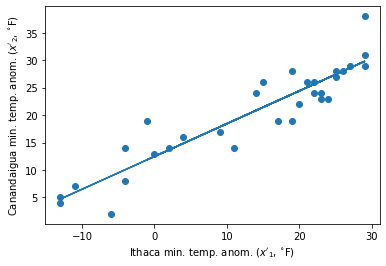

In [ ]:
# Subset just the Ithaca and Canandaigua data and compute their anomalies
idf = df1[df1['Location'].isin(['Ithaca'])]
x = idf.MinTemp_Far.values
cdf = df1[df1['Location'].isin(['Canandaigua'])]
y = cdf.MinTemp_Far.values

# Calculate n, b and a
n = x.shape[0]
b = (n*np.sum(x*y)-np.sum(x)*np.sum(y))\
/(n*np.sum(x**2)-((np.sum(x))**2))
a = y.mean() - b*x.mean()
# Determine the least squares guess at 'y' (the Canandaigua temperature)
y_lr = a + b*x;

# Make the plot using matplotlib (plt)
plt.scatter(x,y)
plt.plot(x,y_lr)
plt.xlabel('Ithaca min. temp. ($x$, $^{\circ}$F)')
plt.ylabel('Canandaigua min. temp. ($y$, $^{\circ}$F)')


This reveals the kind of relationship we were after. Now let's take a closer look at the uncertainty. 

The mean square of the resudials or MSE is often used as an estimate of the uncertainty but in fact we need to use the predcition variance which is

$$ s^2_{\hat{y}} = s_e^2\left[ 1 + \frac{1}{n} + \frac{(x_0 - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}\right].$$

We can also determine the uncertainty in the fit line itself via the 'variance of the conditional mean'

$$ s^2_{\hat{y}|x_0} = s_e^2\left[\frac{1}{n} + \frac{(x_0 - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}\right].$$






Text(0, 0.5, 'Canandaigua min. temp. ($y$, $^{\\circ}$F)')

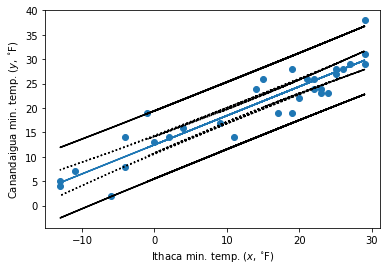

In [ ]:
# Determine the mean square error, the prediciton variance and variance of the 
# conditional mean
se2  = (1/(n-2))*sum((y-y_lr)**2)
sy2 = se2*(1+ (1/n) + (x-x.mean())**2/(sum((x-x.mean())**2)))
syx02 = se2*((1/n) + (x-x.mean())**2/(sum((x-x.mean())**2)))
# Plot
plt.scatter(x,y)
plt.plot(x,y_lr)
plt.plot(x,y_lr+1.96*np.sqrt(sy2),'k',x,y_lr-1.96*np.sqrt(sy2),'k')
plt.plot(x,y_lr+1.96*np.sqrt(syx02),'k:',x,y_lr-1.96*np.sqrt(syx02),'k:')
plt.xlabel('Ithaca min. temp. ($x$, $^{\circ}$F)')
plt.ylabel('Canandaigua min. temp. ($y$, $^{\circ}$F)')

Moving to other forms of linear regression we can use some features of numpy to find the regressions coefficients.

If we want to fit a polynomial of the form

$$ y = b_0 + b_1 x +  b_2 x^2 + ... + b_K x^K$$

we can use numpy's 'polyfit' function where the 1st and second arguments are the x and y values and third is the order of the polynomial (K). Let's check this works for our previous case (which was an order 1 polynomial).

In [ ]:
[b_poly,a_poly] =  np.polyfit(x,y,1)
print(a,b)
print(a_poly,b_poly)

12.459451311425987 0.597411933860532
12.459451311425983 0.5974119338605316


The coeffcients are basically the same. That was a case of using 'derived' predictors. If we want to use mupltiple predictors or any arbitrary derived predictors then it is more straight forward to set the problem up in matrix form and using numpy's linalg package's lsqlin function.



In [ ]:
#Make a 2 by n matrix with 1s as the first column and the predictor x as the second
A = np.array([1+0*x,x]).transpose()
# Now we have A b = y and we want to determine b
lsq  = np.linalg.lstsq(A,y)
print(lsq[0][0],lsq[0][1])

12.459451311425987 0.597411933860532


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


## 3. NWP and MOS models

We will now look at a hindcast of global surface air temperature and compare this to a station temperature observations in Hobart.

Again we are going to 'mount' the appropriate github directory which requires us to use 'bash'.

In [ ]:
%%bash
# Mounting requires a special 'bash' command
rm -rf ./MATH5271
git clone https://github.com/janzika/MATH5271.git

Cloning into 'MATH5271'...


Firstly we will look at station data for maximum temperature from the Hobart weather station. Here is some of the meta data describing the station.

I downloaded this from http://www.bom.gov.au/climate/data/ and searched for "Hobart". I have downloaded just 2020 data.

** Station Details **

Bureau of Meteorology station number: 94029

Station name: HOBART (ELLERSLIE ROAD)

Latitude (decimal degrees, south negative): -42.89

Longitude (decimal degrees, east positive): 147.33

Height of station above mean sea level (metres): 51

State: TAS

In [ ]:
df = pd.read_csv('./MATH5271/IDCJAC0010_094029_2020_Data.csv')
y = df['Maximum temperature (Degree C)'].values
df

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,94029,2020,1,1,23.3,1,Y
1,IDCJAC0010,94029,2020,1,2,25.9,1,Y
2,IDCJAC0010,94029,2020,1,3,20.7,1,Y
3,IDCJAC0010,94029,2020,1,4,28.1,1,Y
4,IDCJAC0010,94029,2020,1,5,22.9,1,Y
...,...,...,...,...,...,...,...,...
361,IDCJAC0010,94029,2020,12,27,26.4,1,Y
362,IDCJAC0010,94029,2020,12,28,20.9,1,Y
363,IDCJAC0010,94029,2020,12,29,22.9,1,Y
364,IDCJAC0010,94029,2020,12,30,21.4,1,Y


Secondly we are going to look at global data from the NCEP Global re-analysis. 

This is a global simulation run by various US agencies to recreate past weather and climate.

https://psl.noaa.gov/repository/

In [ ]:
ds = xr.open_mfdataset('./MATH5271/air.sfc.2020.nc')
ds

/usr/local/lib/python3.7/dist-packages/xarray/conventions.py:520: SerializationWarning: variable 'air' has multiple fill values {-99, 32767}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 366)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(366, 73, 144), meta=np.ndarray>
    head     (time) int16 dask.array<chunksize=(366,), meta=np.ndarray>
Attributes:
    title:          Once daily NCEP geopotential height data 
    delta_time:     once daily
    supplier:       NCEP
    producer:       NCEP
    history:        created 2019/12 by Hoop (netCDF3)
    description:    Data is from NCEP initialized analysis\n(2x/day).  It con...
    platform:       Model
    Conventions:    CF-1.2
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.html
    dataset_title:  NCEP Global Data Assimilation System GDAS

Let's plot the data for one day and see where Hobart sits in the global context.

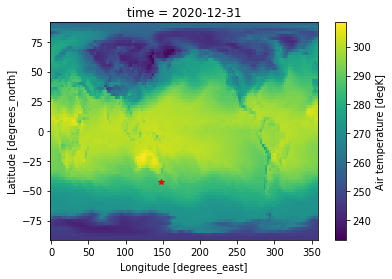

In [ ]:
var = ds.air
var.sel(time='2020-12-31').plot()
plt.plot(147.33,-42.89,'r*')

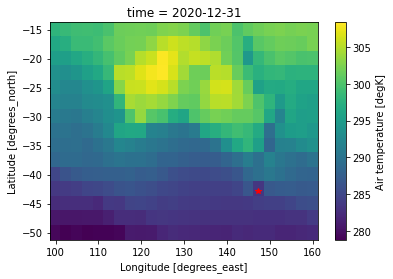

In [ ]:
var = ds.air
TAS_LON = [100,160];
TAS_LAT = [-15,-50];
var.sel(time='2020-12-31',lat=slice(TAS_LAT[0],TAS_LAT[1]),lon=slice(TAS_LON[0],TAS_LON[1])).plot()
plt.plot(147.33,-42.89,'r*')

Now we can pull out some nearby grid cells and plot the in situ Hobart data and the NCEP data along side one and other.

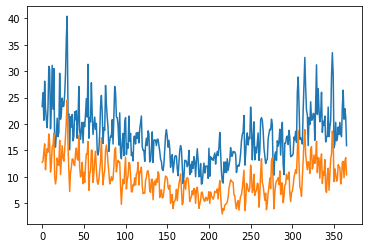

In [ ]:
x1 = var.sel(lon=147.5,lat=-42.5).values-273.15
x2 = var.sel(lon=147.5,lat=-45).values-273.15
x3 = var.sel(lon=145,lat=-42.5).values-273.15

plt.plot(y)
plt.plot(x1)

Let's now use the matrix approach to regress the dailay average NCEP forecast onto the daily maximum Hobart temps.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


4.993931128948213 1.2988993650569913


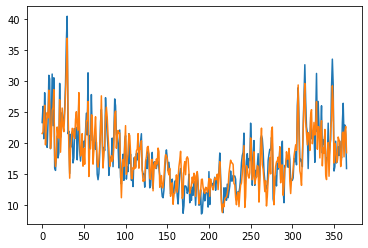

In [ ]:
A = np.array([1+0*x1,x1]).transpose()
lsq  = np.linalg.lstsq(A,y)
y_lr = lsq[0][0] + x1*lsq[0][1];
plt.plot(df['Maximum temperature (Degree C)'])
plt.plot(y_lr)
print(lsq[0][0],lsq[0][1])

As before we can look at the fit and the uncertainty intervals.

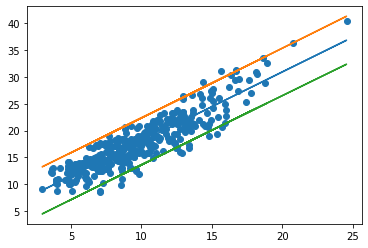

In [ ]:
n = y_lr.shape[0]
se2  = (1/(n-2))*np.sum((y-y_lr)**2)
sy2 = se2*(1+ (1/n) + (x1-x1.mean())**2/(np.sum((x1-x1.mean())**2)))
syx02 = se2*((1/n) + (x1-x1.mean())**2/(np.sum((x1-x1.mean())**2)))
plt.scatter(x1,y)
plt.plot(x1,y_lr)
plt.plot(x1,y_lr+1.96*np.sqrt(sy2))
plt.plot(x1,y_lr-1.96*np.sqrt(sy2))


## 4. Exercise

Split into small teams and work on one of the following:

*   Consider other predictor grid cells nearby. Why do they fit differently and can they help improve the predicitons?;
*   Consider dervided predictors such as x^2 and or harmonics.
